# Data Explanation
- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

# Package

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Load Data

In [16]:
df = pd.read_csv(r"./customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Cleaning & EDA

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Check data distribution
features_check = ['num_passengers','purchase_lead','length_of_stay', 'flight_hour', 'flight_duration']

for feature in features_check:
    plt.figure(figsize=(5,3))
    df[feature].plot(kind='hist')
    plt.title(f"Distribution of {feature}")
    plt.tight_layout()
    plt.show()

# Training Model

## Mutual Information Score
Purpose: Helps in feature selection by quantifying the amount of information obtained about the target variable through each feature.

In [17]:
x = df.drop(['booking_complete'],axis=1)
y = df['booking_complete']

# For Mutual Information
x_mutual = x.copy()

In [18]:
#changing object dtype to int dtype
for colname in x_mutual.select_dtypes("object"):
    x_mutual[colname], _ = x_mutual[colname].factorize()

mi_scores = mutual_info_classif(x_mutual, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_mutual.columns)
mi_scores = mi_scores.sort_values(ascending=False)

top_6_columns = mi_scores.head(6).index.to_list()

print(f'Top 6 MI Score = {top_6_columns}')

mi_scores

Top 6 MI Score = ['route', 'booking_origin', 'flight_duration', 'wants_extra_baggage', 'length_of_stay', 'flight_hour']


route                    0.051581
booking_origin           0.049298
flight_duration          0.016305
wants_extra_baggage      0.009907
length_of_stay           0.008400
flight_hour              0.005227
wants_in_flight_meals    0.004192
wants_preferred_seat     0.003988
num_passengers           0.002905
purchase_lead            0.002479
sales_channel            0.000957
trip_type                0.000867
flight_day               0.000483
Name: MI Scores, dtype: float64

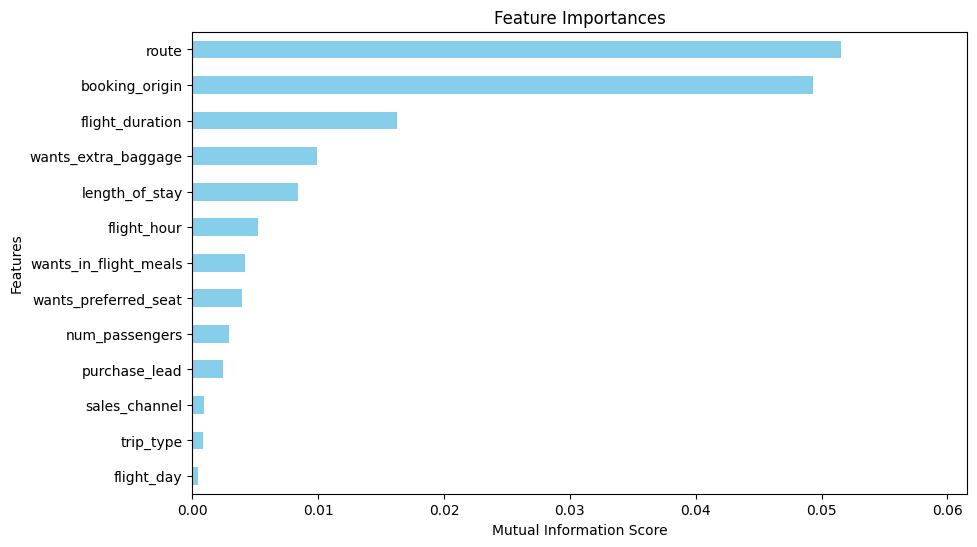

In [47]:
# Sort the MI scores in ascending order and select the top 6
sorted_mi_scores = mi_scores.sort_values(ascending=True)

# Plotting the mutual information scores
plt.figure(figsize=(10, 6))
sorted_mi_scores.plot(kind='barh', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.xlim(0, sorted_mi_scores.max() + 0.01)  # Adjust x-axis limit for better visualization
plt.show()

In [20]:
# Take the 6 columns which has the highest MI_Score

x_mi_top = pd.DataFrame()

for column in top_6_columns:
    x_mi_top[column] = x[column]

x_mi_top

,route,booking_origin,flight_duration,wants_extra_baggage,length_of_stay,flight_hour
0,AKLDEL,New Zealand,5.52,1,19,7
1,AKLDEL,New Zealand,5.52,0,20,3
2,AKLDEL,India,5.52,1,22,17
3,AKLDEL,New Zealand,5.52,0,31,4
4,AKLDEL,India,5.52,1,22,15
...,...,...,...,...,...,...
49995,PERPNH,Australia,5.62,1,6,9
49996,PERPNH,Australia,5.62,0,6,4
49997,PERPNH,Australia,5.62,0,6,22
49998,PERPNH,Australia,5.62,1,6,11


## Encode Data

In [31]:
# Sparse
# encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')

#Dense
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df[['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']])
x_encode = encoder.transform(df[['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']])

x.drop(columns=['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'], inplace=True)

# Sparse
'''x_encoded = pd.DataFrame.sparse.from_spmatrix(x_encode \
                                              , columns=encoder.get_feature_names_out(\
                                                  ['sales_channel', 'trip_type', 'flight_day']))'''
# Dense
x_encoded = pd.DataFrame(x_encode, columns=encoder.get_feature_names_out(\
    ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']))

x = pd.concat([x, x_encoded], axis = 1)

x

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Internet,sales_channel_Mobile,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,1,0,0,5.52,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,112,20,3,0,0,0,5.52,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,243,22,17,1,1,0,5.52,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,96,31,4,0,0,1,5.52,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,68,22,15,1,0,1,5.52,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,1,0,1,5.62,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49996,1,111,6,4,0,0,0,5.62,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49997,1,24,6,22,0,0,1,5.62,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49998,1,15,6,11,1,0,1,5.62,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Encoders Save and Load

In [ ]:
# Save
with open('onehot_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
# Load
with open('onehot_encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)

## Train

In [32]:
# Full Feature
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=69)

# Top 6 MI_Score
# For simplicity, I will use pd.get_dummies to test will it work better or not
x_mi_top = pd.get_dummies(x_mi_top)
x_train_mi, x_test_mi, y_train_mi, y_test_mi = train_test_split(x_mi_top, y, test_size=0.3, random_state=69)

### Random Forest (All Features)

In [33]:
# Split Data
forest_model= RandomForestClassifier(n_estimators=100, random_state=1, max_depth=None)
forest_model.fit(x_train, y_train)
preds= forest_model.predict(x_test)

print('ACCURACY: ',accuracy_score(y_test,preds)*100)
print('AUC score: ',roc_auc_score(y_test,preds))

ACCURACY:  84.79333333333334
AUC score:  0.5488927030286997


### Random Forest (6 Features)

In [25]:
# Split Data
forest_model= RandomForestClassifier(n_estimators=100, random_state=1, max_depth=None)
forest_model.fit(x_train_mi, y_train_mi)
preds= forest_model.predict(x_test_mi)

print('ACCURACY: ',accuracy_score(y_test_mi,preds)*100)
print('AUC score: ',roc_auc_score(y_test_mi,preds))

ACCURACY:  82.3
AUC score:  0.5810046978098523


### XGBoost (All Features)

In [34]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)
prediction_xgb = xgb_model.predict(x_test)
print('ACCURACY: ',accuracy_score(y_test, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_test,prediction_xgb))

ACCURACY:  84.54
AUC score:  0.5362174028718693


### XGBoost (6 Features)

In [27]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train_mi, y_train_mi)
prediction_xgb = xgb_model.predict(x_test_mi)
print('ACCURACY: ',accuracy_score(y_test_mi, prediction_xgb)*100)
print('AUC score: ',roc_auc_score(y_test_mi,prediction_xgb))

ACCURACY:  84.51333333333334
AUC score:  0.5309141755684644


I will pick the random forest with all features included to be the final model to predict future order as it has the highest accuracy, which is around 84,79.